<center> <h1> GANs on cell profiles </center> </h1>


# 1) Adaptation of naive_classifier notebook to get trained xgboost compatible with torch
The goal of this Notebook is to adapt the [example of Diane](https://github.com/dlmbl/knowledge_extraction/blob/main/solution.ipynb) to create GANs but on cell profiles so 1D data instead of 2D. 

In [2]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cupy as cp

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from xgboost import XGBClassifier

from features_engineering import features_drop_corr
from features_engineering import features_drop_corr_gpu

from data_split import StratifiedGroupKFold_custom

import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

import lightning as L

import custom_dataset
import captum.attr
from captum.attr import IntegratedGradients
from lightning_parallel_training import LightningModel
import conv_model
from pathlib import Path

# a) Load Dataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
metadata_df = pd.read_csv("target2_eq_moa2_metadata", index_col="ID")
features_df = pd.read_csv("target2_eq_moa2_features", index_col="ID")
nan_col = features_df.columns[features_df.isna().sum(axis=0) > 0]
nan_col, len(nan_col)
inf_col = features_df.columns[(features_df == np.inf).sum(axis=0) > 0]
inf_col, len(inf_col)
features_df = features_df[features_df.columns[(features_df.isna().sum(axis=0) == 0) & 
                                            ((features_df == np.inf).sum(axis=0) == 0) & 
                                            (features_df.std() != 0)]]
metadata_df = metadata_df.assign(moa_id=LabelEncoder().fit_transform(metadata_df["moa"]))
features_df = features_df.sort_index().reset_index(drop=True)
metadata_df = metadata_df.sort_index().reset_index()

In [5]:
kfold = list(StratifiedGroupKFold_custom().split(
    features_df, metadata_df["moa_id"], metadata_df["Metadata_InChIKey"]))

In [6]:
# X = torch.tensor(features_df.values, dtype=torch.float)
# y = torch.tensor(metadata_df["moa_id"].values, dtype=torch.long)
# dataset_fold = {i: 
#                 {"train": custom_dataset.RowDataset(X[kfold[i][0]], 
#                                                       y[kfold[i][0]]),
#                  "test": custom_dataset.RowDataset(X[kfold[i][1]], 
#                                                      y[kfold[i][1]])}
#                 for i in range(len(kfold))}

X = torch.tensor(features_df.values, dtype=torch.float)
y = torch.tensor(metadata_df["moa_id"].values, dtype=torch.long)

dataset_fold = {i: 
                {"train": 0,
                 "test": 0} for i in range(len(kfold))}
scaler_fold = {i: RobustScaler() for i in range(len(kfold))}
for i in range(len(kfold)):
    scaler_fold[i].fit(X[kfold[i][0]])
    dataset_fold[i]["train"] =  custom_dataset.RowDataset(torch.tensor(scaler_fold[i].transform(X[kfold[i][0]]), 
                                                                       dtype=torch.float),
                                                          y[kfold[i][0]])
    dataset_fold[i]["test"] = custom_dataset.RowDataset(torch.tensor(scaler_fold[i].transform(X[kfold[i][1]]), 
                                                                     dtype=torch.float),
                                                        y[kfold[i][1]])


# b) Load trained deep learning model trained with gans_profiles_script

In [7]:
# trained_model_path = [
#     "SimpleNN_profiles_fold_0epoch=999-train_acc=0.77-val_acc=0.57.ckpt",
#     "SimpleNN_profiles_fold_1epoch=999-train_acc=0.79-val_acc=0.37.ckpt",
#     "SimpleNN_profiles_fold_2epoch=999-train_acc=0.77-val_acc=0.46.ckpt",
#     "SimpleNN_profiles_fold_3epoch=999-train_acc=0.81-val_acc=0.35.ckpt",
#     "SimpleNN_profiles_fold_4epoch=999-train_acc=0.79-val_acc=0.47.ckpt"
#     ]


trained_model_path = [
    "SimpleNN_profiles_fold_0_RobustScaler_epoch=461-train_acc=0.83-val_acc=0.55.ckpt",
    "SimpleNN_profiles_fold_1_RobustScaler_epoch=377-train_acc=0.87-val_acc=0.45.ckpt",
    "SimpleNN_profiles_fold_2_RobustScaler_epoch=145-train_acc=0.72-val_acc=0.50.ckpt",
    "SimpleNN_profiles_fold_3_RobustScaler_epoch=341-train_acc=0.88-val_acc=0.41.ckpt",
    "SimpleNN_profiles_fold_4_RobustScaler_epoch=209-train_acc=0.79-val_acc=0.51.ckpt"
                     ]

trained_model = {i: LightningModel.load_from_checkpoint(Path("lightning_checkpoint_log") / trained_model_path[i], 
                                                     model=conv_model.SimpleNN).model.eval() #disable batchnorm and dropout
              for i in list(dataset_fold.keys())}

In [8]:
train_auc_fold = []
train_f1_fold = []
train_acc_fold = []
test_auc_fold = []
test_f1_fold = []
test_acc_fold = []

# Perform stratified k-fold cross-validation
for i in tqdm(list(dataset_fold.keys())):
    # Initialize the Classifier
    model = trained_model[i].to(device)
    X_train, y_train = dataset_fold[i]["train"][:]
    X_test, y_test = dataset_fold[i]["test"][:]

    # Fit the classifier on training data
    with torch.no_grad():
        #model.eval()
        # Predict probabilities of the positive class for train and test data
        y_train_scores = model(X_train.to(device))  
        y_train_pred = torch.argmax(y_train_scores, dim=1)
        y_test_scores = model(X_test.to(device))    
        y_test_pred = torch.argmax(y_test_scores, dim=1)
    
           
        train_auc = roc_auc_score(y_train.cpu().detach().numpy(), y_train_scores.cpu().detach().numpy(),
                                  multi_class="ovr",
                                  average="macro")
    
        test_auc = roc_auc_score(y_test.cpu().detach().numpy(), y_test_scores.cpu().detach().numpy(),
                                 multi_class="ovr",
                                 average="macro")
        
        train_f1 = f1_score(y_train.cpu().detach().numpy(), y_train_pred.cpu().detach().numpy(), 
                   average="macro")
        
        test_f1 = f1_score(y_test.cpu().detach().numpy(), y_test_pred.cpu().detach().numpy(), 
                           average="macro")
    
        train_acc = accuracy_score(y_train.cpu().detach().numpy(), y_train_pred.cpu().detach().numpy())
        test_acc = accuracy_score(y_test.cpu().detach().numpy(), y_test_pred.cpu().detach().numpy())
        
                           
        print(f"Train ROC-AUC: {train_auc:.4f} - f1: {train_f1:.4f} - acc: {train_acc:.4f} \n", 
              f"Test ROC-AUC: {test_auc:.4f} - f1: {test_f1:.4f} - acc: {test_acc:.4f}")
        # Append train and test accuracy, train and test AUC score to respective lists
        train_auc_fold.append(train_auc)
        train_f1_fold.append(train_f1)
        train_acc_fold.append(train_acc)
        test_auc_fold.append(test_auc)
        test_f1_fold.append(test_f1)
        test_acc_fold.append(test_acc)
        
    
# Average metrics across all folds
mean_train_auc = np.mean(train_auc_fold)
mean_train_f1 = np.mean(train_f1)
mean_train_acc = np.mean(train_acc_fold)
mean_test_auc = np.mean(test_auc_fold)
mean_test_f1 = np.mean(test_f1_fold)
mean_test_acc = np.mean(test_acc_fold)
    
    
print(f"Mean over fold Train ROC-AUC Score: {mean_train_auc:.4f}")
print(f"Mean over fold Train f1 Score: {mean_train_f1:.4f}")
print(f"Mean over fold Train accuracy Score: {mean_train_acc:.4f}")
print(f"Mean over fold Test ROC-AUC Score: {mean_test_auc:.4f}")
print(f"Mean over fold Test f1 Score: {mean_test_f1:.4f}")
print(f"Mean over fold Test accuracy Score: {mean_test_acc:.4f}")


100%|██████████| 5/5 [00:00<00:00, 80.66it/s]

Train ROC-AUC: 0.9608 - f1: 0.8694 - acc: 0.8684 
 Test ROC-AUC: 0.8417 - f1: 0.5210 - acc: 0.5421
Train ROC-AUC: 0.9683 - f1: 0.8915 - acc: 0.8893 
 Test ROC-AUC: 0.7529 - f1: 0.4236 - acc: 0.4467
Train ROC-AUC: 0.9231 - f1: 0.7325 - acc: 0.7246 
 Test ROC-AUC: 0.8202 - f1: 0.4880 - acc: 0.5000
Train ROC-AUC: 0.9789 - f1: 0.9012 - acc: 0.9002 
 Test ROC-AUC: 0.7241 - f1: 0.3556 - acc: 0.4124
Train ROC-AUC: 0.9414 - f1: 0.8176 - acc: 0.8107 
 Test ROC-AUC: 0.8206 - f1: 0.4985 - acc: 0.5103
Mean over fold Train ROC-AUC Score: 0.9545
Mean over fold Train f1 Score: 0.8176
Mean over fold Train accuracy Score: 0.8386
Mean over fold Test ROC-AUC Score: 0.7919
Mean over fold Test f1 Score: 0.4573
Mean over fold Test accuracy Score: 0.4823


## c) Comparison of the deep learning model to xgboost

In [9]:
class SklearnModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, X):
        X_np = X.cpu().detach().numpy()
        return torch.tensor(self.model.predict_proba(X_np)).to(X.device)
        
def train_classifier(dataset_fold, 
                     classifier,
                     classifier_params): # True, False  
    
    trained_model = {i: 0 for i in list(dataset_fold.keys())}
    
    # Lists to store precision-recall auc score, train and test accuracy for each fold
    train_auc_fold = []
    train_f1_fold = []
    train_acc_fold = []
    test_auc_fold = []
    test_f1_fold = []
    test_acc_fold = []
    
    # Perform stratified k-fold cross-validation
    for i in tqdm(list(dataset_fold.keys())):
        # Initialize the Classifier
        model = classifier(**classifier_params)
        X_train, y_train = list(map(lambda x: x.cpu().detach().numpy(), dataset_fold[i]["train"][:]))
        X_test, y_test = list(map(lambda x: x.cpu().detach().numpy(), dataset_fold[i]["test"][:]))

        # Fit the classifier on training data
        model.fit(X_train, y_train)
        
        # Predict probabilities of the positive class for train and test data
        y_train_scores = model.predict_proba(X_train)  
        y_train_pred = model.predict(X_train)
        y_test_scores = model.predict_proba(X_test)    
        y_test_pred = model.predict(X_test)

           
        train_auc = roc_auc_score(y_train, y_train_scores,
                                  multi_class="ovr",
                                  average="macro",
                                  labels=model.classes_)

        test_auc = roc_auc_score(y_test, y_test_scores,
                                 multi_class="ovr",
                                 average="macro",
                                 labels=model.classes_)
        
        train_f1 = f1_score(y_train, y_train_pred, 
                   average="macro",
                   labels=model.classes_)
        
        test_f1 = f1_score(y_test, y_test_pred, 
                           average="macro",
                           labels=model.classes_)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
                           
        print(f"Train ROC-AUC: {train_auc:.4f} - f1: {train_f1:.4f} - acc: {train_acc:.4f} \n", 
              f"Test ROC-AUC: {test_auc:.4f} - f1: {test_f1:.4f} - acc: {test_acc:.4f}")
        # Append train and test accuracy, train and test AUC score to respective lists
        train_auc_fold.append(train_auc)
        train_f1_fold.append(train_f1)
        train_acc_fold.append(train_acc)
        test_auc_fold.append(test_auc)
        test_f1_fold.append(test_f1)
        test_acc_fold.append(test_acc)
        

        trained_model[i] = SklearnModel(model)

    # Average metrics across all folds
    mean_train_auc = np.mean(train_auc_fold)
    mean_train_f1 = np.mean(train_f1)
    mean_train_acc = np.mean(train_acc_fold)
    mean_test_auc = np.mean(test_auc_fold)
    mean_test_f1 = np.mean(test_f1_fold)
    mean_test_acc = np.mean(test_acc_fold)
    

    print(f"Mean over fold Train ROC-AUC Score: {mean_train_auc:.4f}")
    print(f"Mean over fold Train f1 Score: {mean_train_f1:.4f}")
    print(f"Mean over fold Train accuracy Score: {mean_train_acc:.4f}")
    print(f"Mean over fold Test ROC-AUC Score: {mean_test_auc:.4f}")
    print(f"Mean over fold Test f1 Score: {mean_test_f1:.4f}")
    print(f"Mean over fold Test accuracy Score: {mean_test_acc:.4f}")
    
    return trained_model

In [10]:
classifier = XGBClassifier
classifier_params = {'device': 'cuda',
  'objective': 'multi:softprob',
  'eval_metric': 'auc',
  'eta': 0.009220975613350597,
  'reg_alpha': 2.0306587420421414,
  'reg_lambda': 0.016003601665119382,
  'gamma': 0.04020765654946003,
  'max_depth': 5,
  'max_leaves': 5,
  'min_child_weight': 7.574433676104173,
  'n_jobs': 192,
  'random_state': 42,
  'subsample': 0.4971871649904771,
  'colsample_bytree': 0.9712341267382383,
  'colsample_bylevel': 0.9994344494972629,
  'colsample_bynode': 0.7014104562833469}#In case of huge imbalance. set between 1-10 is usual in case of usage


trained_model_xgb = train_classifier(dataset_fold, 
                                 classifier,
                                 classifier_params)


  0%|          | 0/5 [00:00<?, ?it/s]/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:13:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
 20%|██        | 1/5 [00:03<00:14,  3.57s/it]

Train ROC-AUC: 0.9546 - f1: 0.7555 - acc: 0.7504 
 Test ROC-AUC: 0.8536 - f1: 0.5155 - acc: 0.5211


 40%|████      | 2/5 [00:07<00:10,  3.53s/it]

Train ROC-AUC: 0.9685 - f1: 0.7918 - acc: 0.7855 
 Test ROC-AUC: 0.7633 - f1: 0.4579 - acc: 0.4518


 60%|██████    | 3/5 [00:10<00:06,  3.47s/it]

Train ROC-AUC: 0.9629 - f1: 0.7577 - acc: 0.7522 
 Test ROC-AUC: 0.8232 - f1: 0.4697 - acc: 0.4742


 80%|████████  | 4/5 [00:13<00:03,  3.44s/it]

Train ROC-AUC: 0.9637 - f1: 0.7926 - acc: 0.7917 
 Test ROC-AUC: 0.6993 - f1: 0.3078 - acc: 0.3454


100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

Train ROC-AUC: 0.9587 - f1: 0.7534 - acc: 0.7453 
 Test ROC-AUC: 0.8403 - f1: 0.5035 - acc: 0.5103
Mean over fold Train ROC-AUC Score: 0.9617
Mean over fold Train f1 Score: 0.7534
Mean over fold Train accuracy Score: 0.7650
Mean over fold Test ROC-AUC Score: 0.7959
Mean over fold Test f1 Score: 0.4509
Mean over fold Test accuracy Score: 0.4605


# 2) Get an attribution
Goal understand what the model has learnt
## a) Visualise attribution with baseline 0

In [11]:
fold = 0
model = trained_model[fold].to(device)
batch_size = 7 #num class as well
batch = []
for i in range(batch_size):
    batch.append(next(row for row in dataset_fold[fold]["train"] if row[1] == i))
X = torch.stack([b[0] for b in batch])
y = torch.tensor([b[1] for b in batch])
X = X.to(device)
y = y.to(device)
# Create an integrated gradients object.
integrated_gradients = IntegratedGradients(model)

# Generated attributions on integrated gradients
attributions = integrated_gradients.attribute(X, target=y).cpu().numpy()

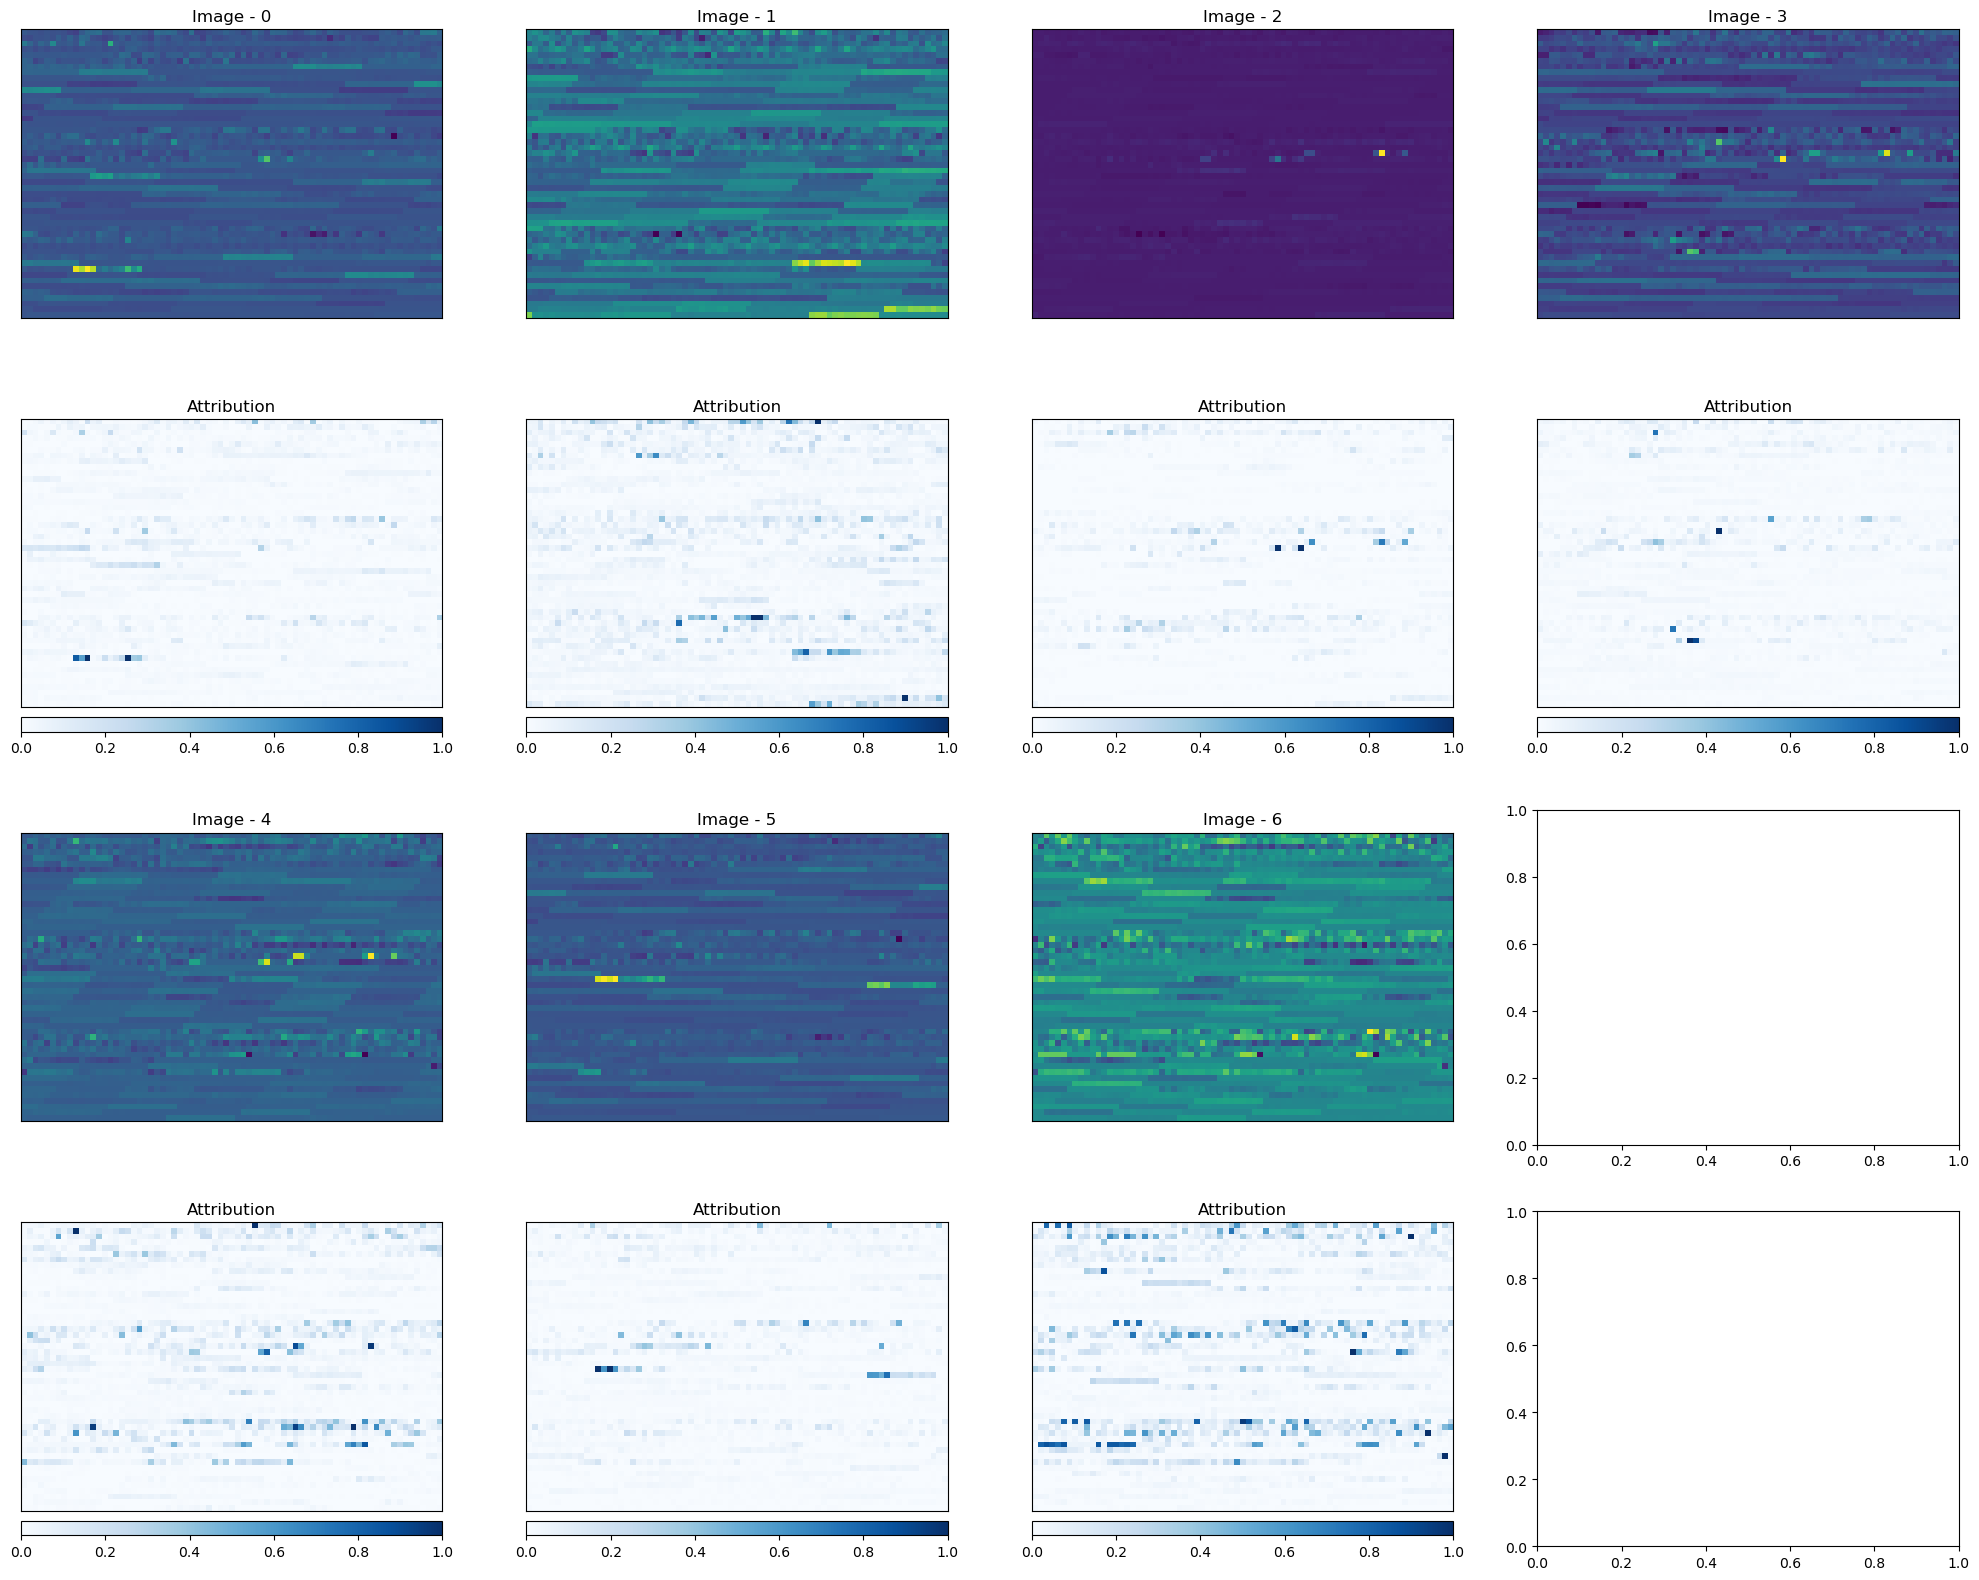

In [12]:
from captum.attr import visualization as viz
import numpy as np

def visualize_attribution(attribution, original_row, class_lbl, plt_fig_axis):
    attribution = np.transpose(attribution, (1, 2, 0))
    original_row = np.transpose(original_row, (1, 2, 0))
    
    viz.visualize_image_attr(
        attribution,
        original_row,
        method="original_image",
        sign="all",
        plt_fig_axis=plt_fig_axis[0],
        show_colorbar=False,
        title=f"Image - {class_lbl}",# "Attribution"],
        use_pyplot=False
        
    )
    viz.visualize_image_attr(
        attribution,
        original_row,
        method="heat_map",
        sign="absolute_value",
        plt_fig_axis=plt_fig_axis[1],
        show_colorbar=True,
        title="Attribution",
        use_pyplot=False
        
    )

     
fig, axes = plt.subplots(4, 4, figsize=(25, 20))
for i, (attr, row, lbl) in enumerate(zip(attributions, X.cpu().numpy(), y.cpu().numpy())):
    visualize_attribution(attr[:].reshape(1, 50, -1), row[:].reshape(1, 50, -1), 
                          class_lbl=lbl, plt_fig_axis=[(fig, axes[2 * (i//4), i%4]), (fig, axes[2 * (i//4) + 1, i%4])])

## b) Visualise attribution with baseline random noise

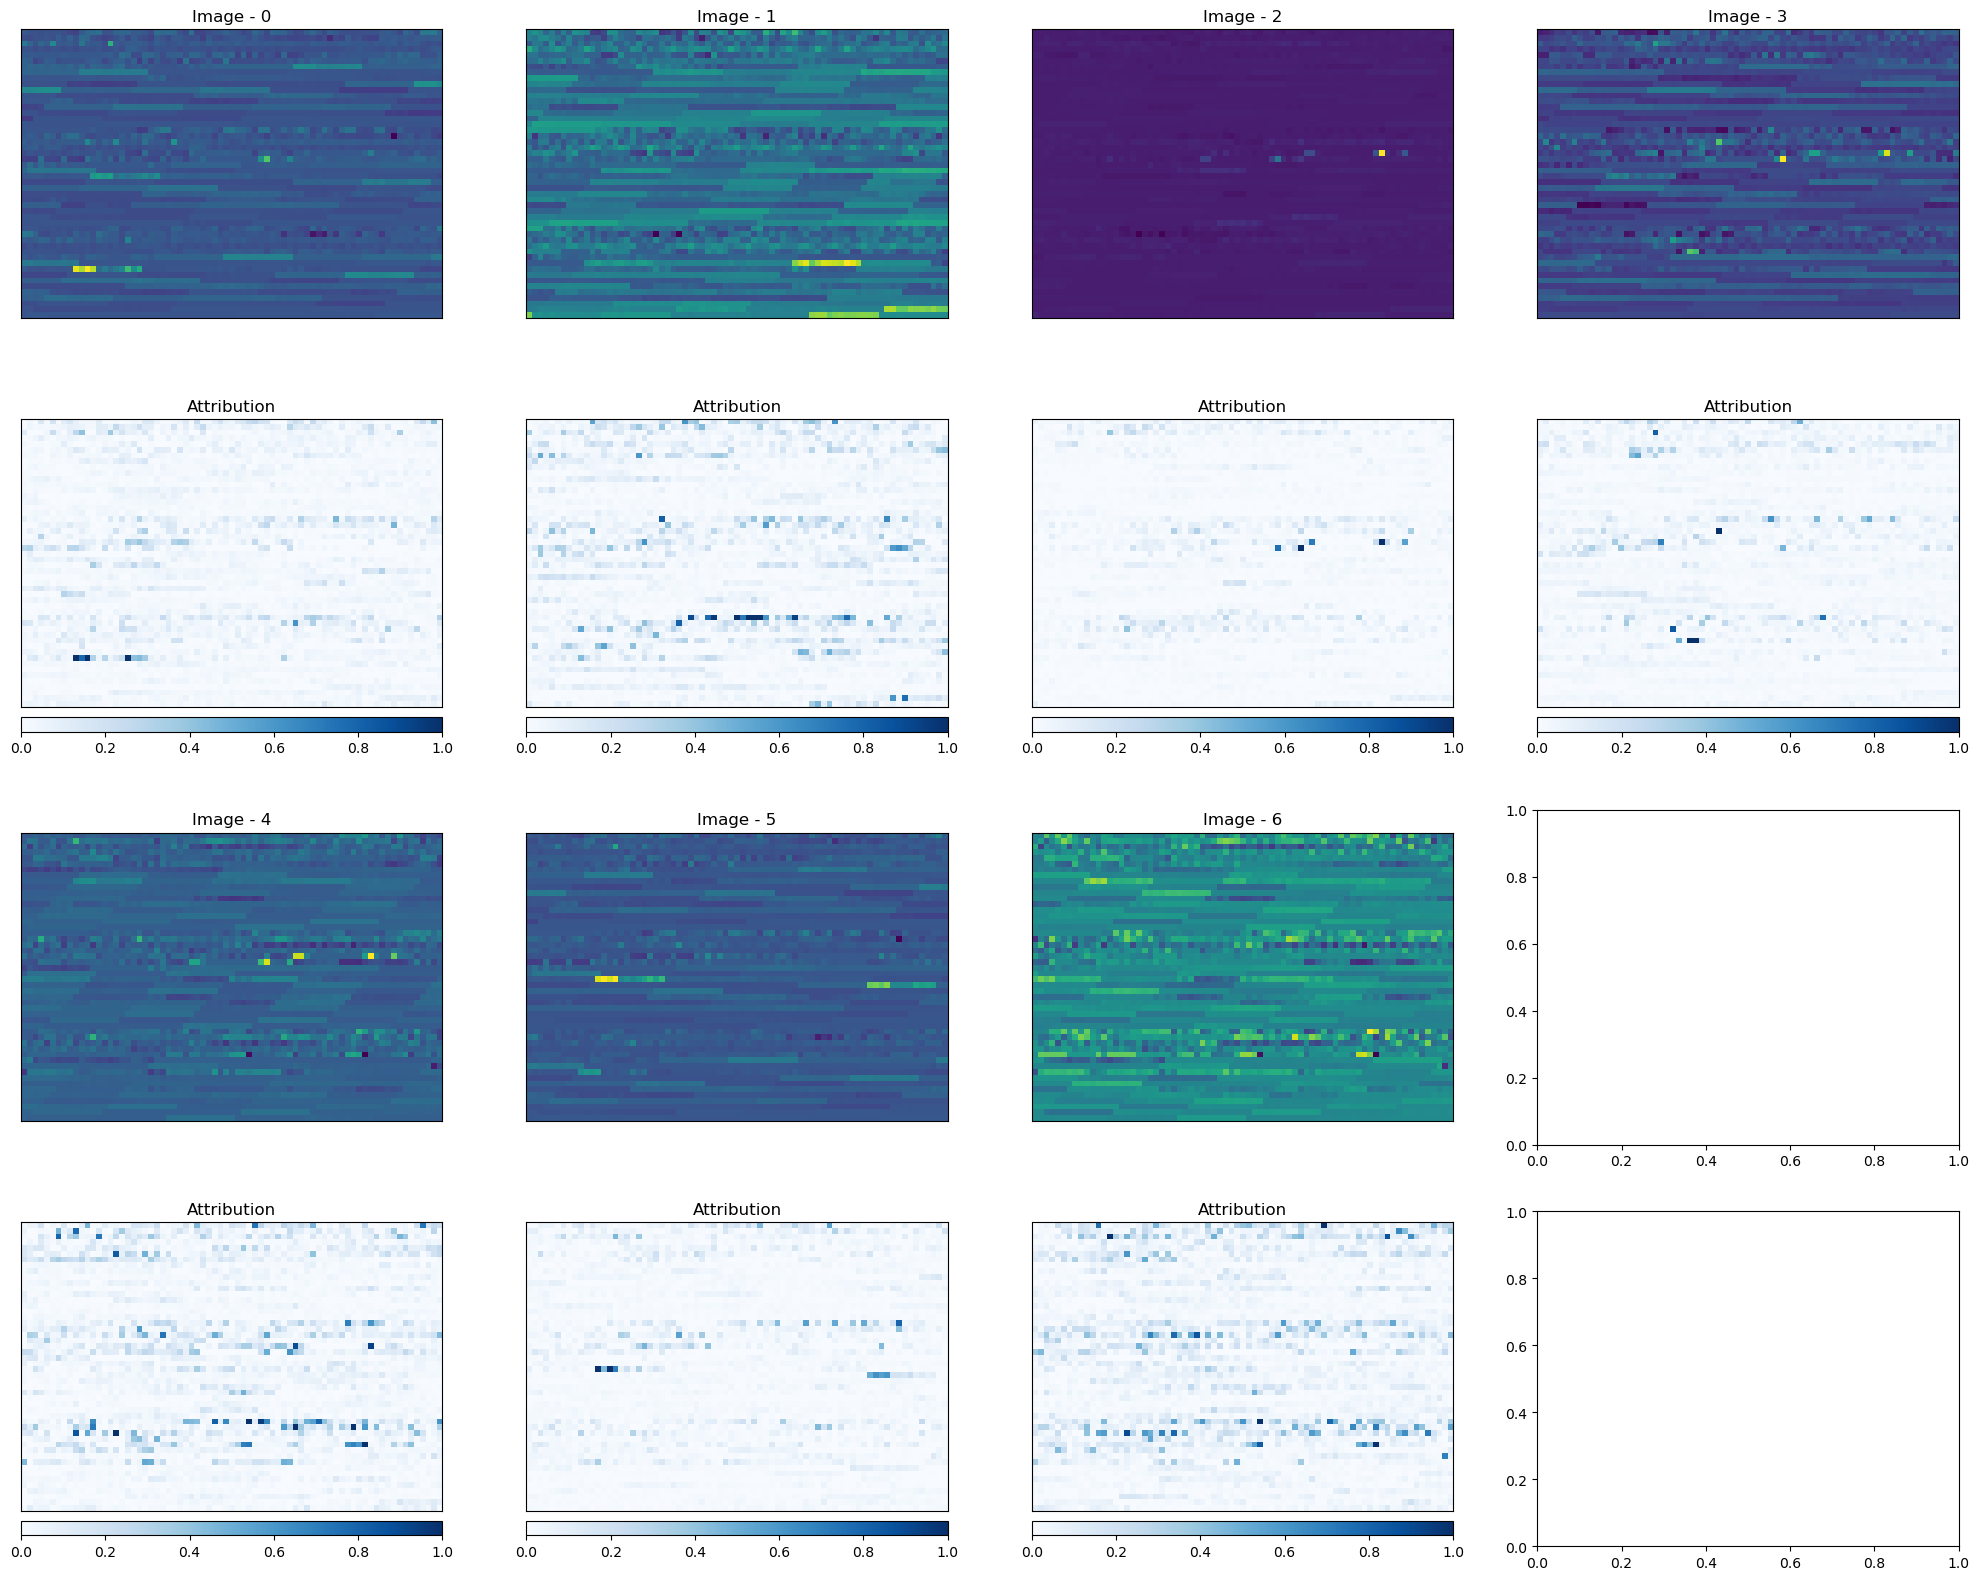

In [13]:
random_baselines = torch.rand_like(X)
# Generate the attributions
attributions_random = integrated_gradients.attribute(
    X, target=y, baselines=random_baselines
)
attributions_random = attributions_random.cpu().numpy()
# Plotting
fig, axes = plt.subplots(4, 4, figsize=(25, 20))
for i, (attr, row, lbl) in enumerate(zip(attributions_random, X.cpu().numpy(), y.cpu().numpy())):
    visualize_attribution(attr[:].reshape(1, 50, -1), row[:].reshape(1, 50, -1), 
                          class_lbl=lbl, plt_fig_axis=[(fig, axes[2 * (i//4), i%4]), (fig, axes[2 * (i//4) + 1, i%4])])

## c) Visualise attribution with blurred image

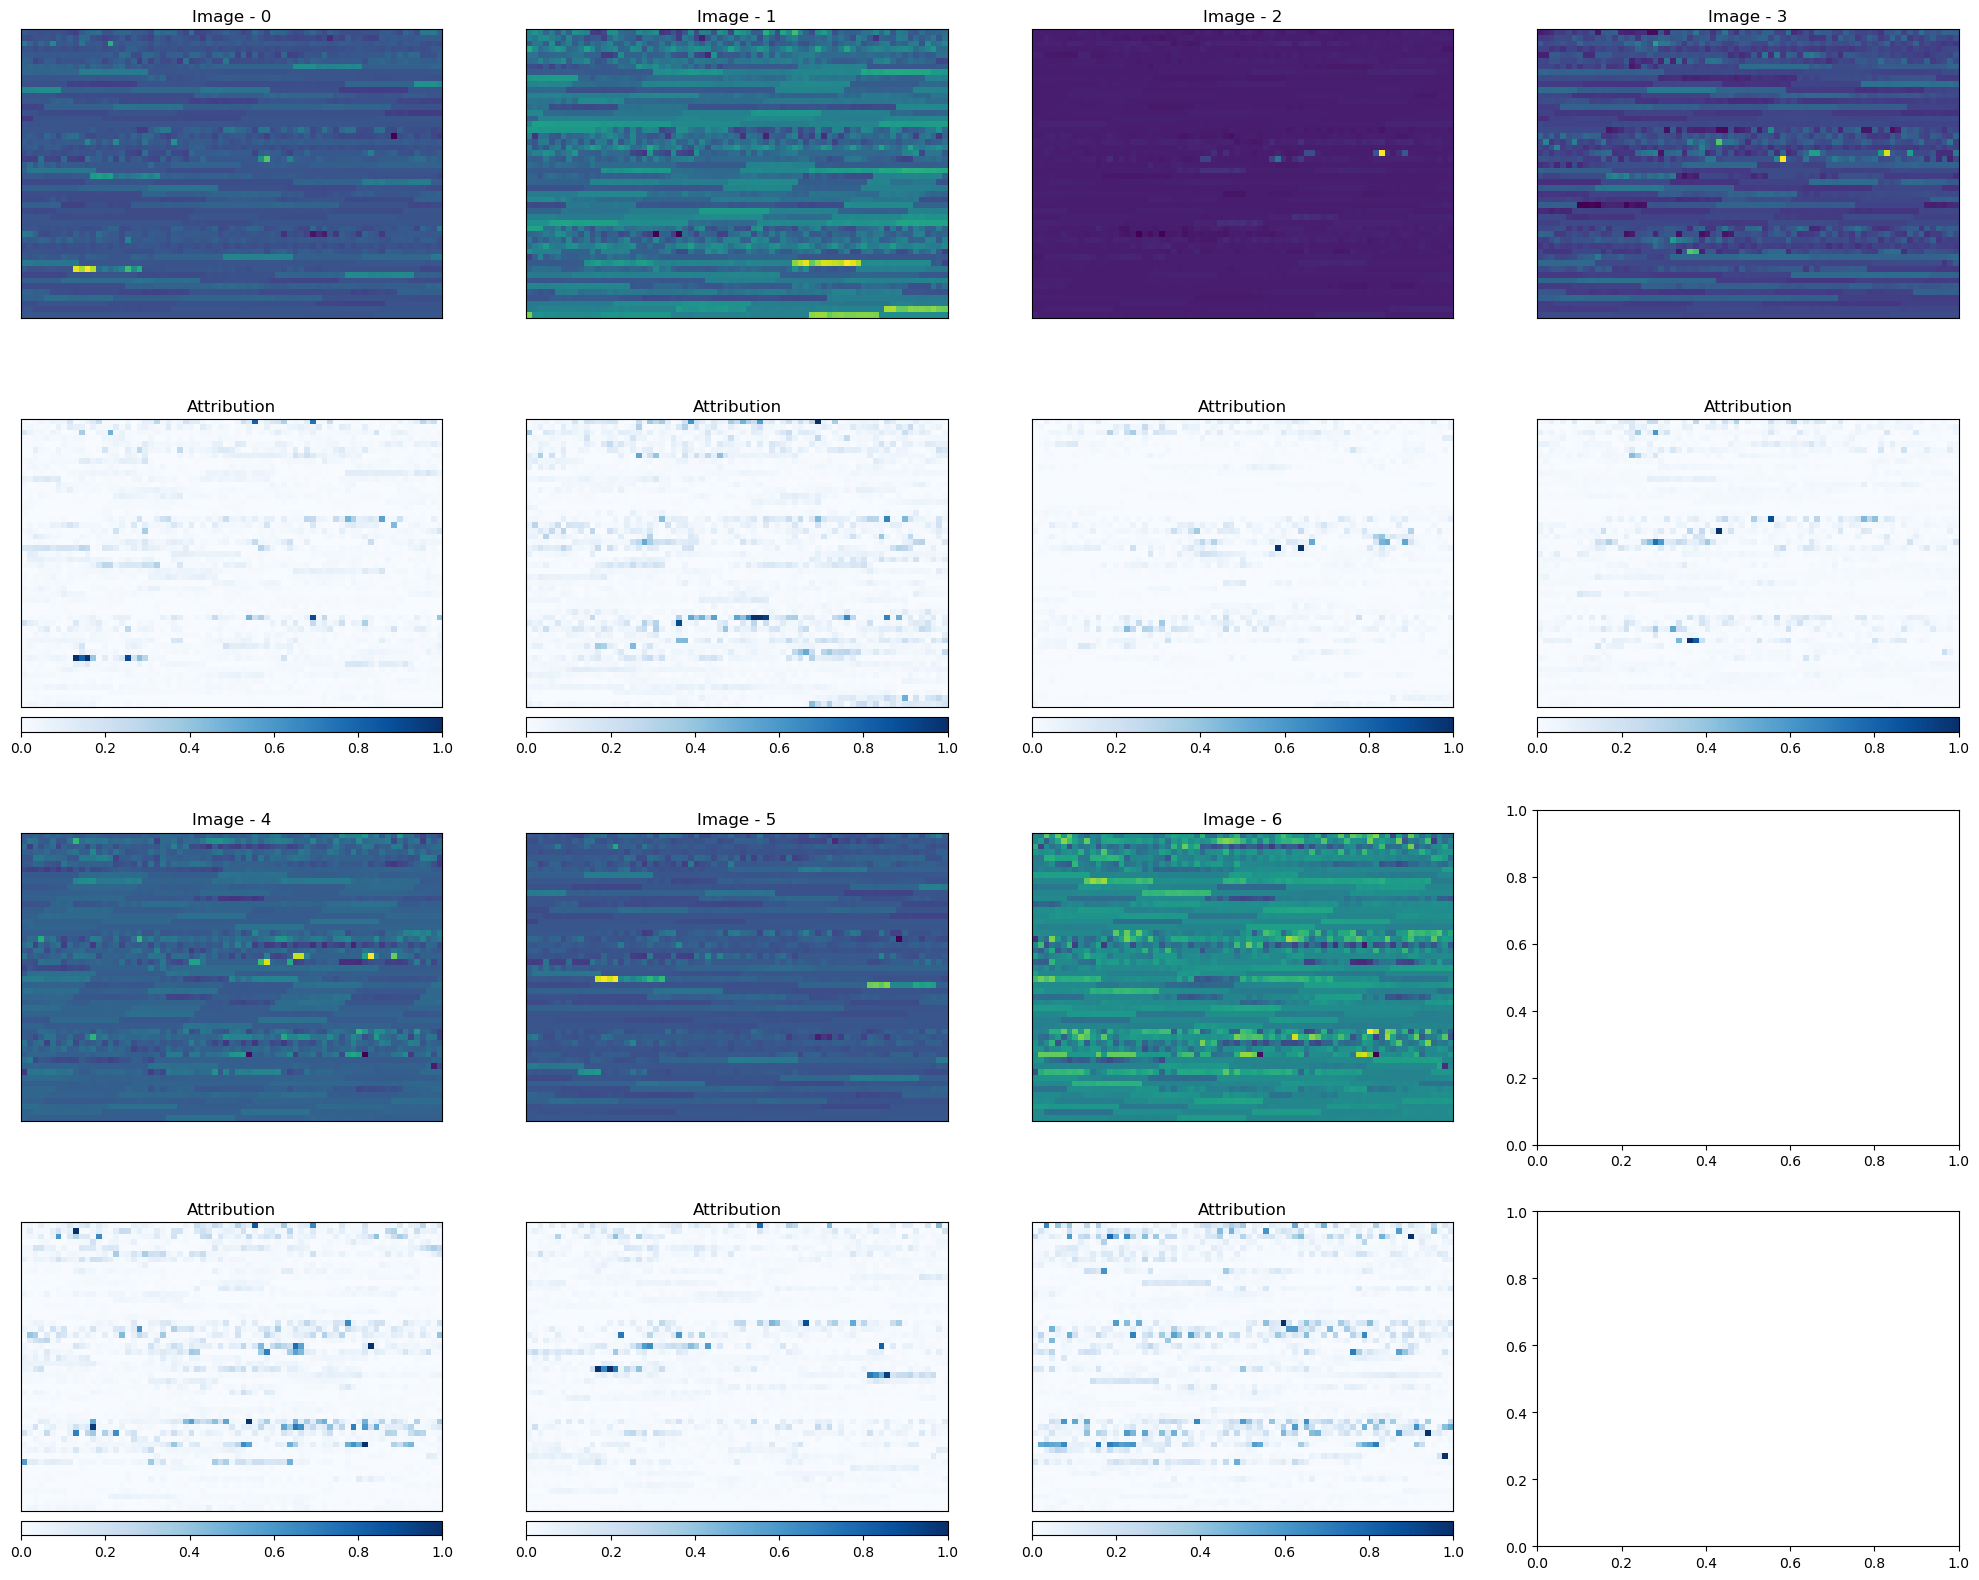

In [14]:
from torchvision.transforms.functional import gaussian_blur

# Baseline
blurred_baselines = gaussian_blur(X.reshape(7, 50, -1), kernel_size=(5, 5)).reshape(7, -1)
# Generate the attributions
attributions_blurred = integrated_gradients.attribute(
    X, target=y, baselines=blurred_baselines
)

attributions_blurred = attributions_blurred.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(25, 20))
for i, (attr, row, lbl) in enumerate(zip(attributions_blurred, X.cpu().numpy(), y.cpu().numpy())):
    visualize_attribution(attr[:].reshape(1, 50, -1), row[:].reshape(1, 50, -1), 
                          class_lbl=lbl, plt_fig_axis=[(fig, axes[2 * (i//4), i%4]), (fig, axes[2 * (i//4) + 1, i%4])])
     

# 3) StarGAN implementation

In [15]:
class VectorGenerator(nn.Module):

    def __init__(self, generator, style_encoder):
        super().__init__()
        self.generator = generator
        self.style_encoder = style_encoder

    def forward(self, x, y):
        """
        x: torch.Tensor
            The source image
        y: torch.Tensor
            The style image
        """
        style = self.style_encoder(y)
        # Concatenate the style vector with the input image
        x = torch.cat([x, style], dim=1)
        return self.generator(x)

In [17]:
style_encoder = conv_model.SimpleNN(3650, 7, hidden_layer_L=[2024, 256, 128, 64, 7], 
                                    p_dopout_L=[0,0,0,0,0], batchnorm=False)
unet = conv_model.VectorUNet(input_dim=3657, hidden_dims=[2048, 1024, 512, 256], 
                                  output_dim=3650)
generator = VectorGenerator(unet, style_encoder=style_encoder)